Sudden drifts or data corruptions such as missing values, violating constraints, and type checking errors.

An important feature is generated by an external API call -> External API has a bug and returns null or -1 by default.

### -> Garbage in, garbage out.

In [1]:
from dataval.dataset import WeatherDataset
from dataval.train import CatBoostTrainer

import os
import matplotlib.pyplot as plt
import pandas as pd

import wandb

os.environ["WANDB_QUIET"] = "true"
run = wandb.init(project="ml-dataval-tutorial")
os.environ["WANDB_NOTEBOOK_NAME"] = "Dataval"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


# Explore corruptions

In [2]:
ds = WeatherDataset(os.path.join(os.getcwd(), "canonical-paritioned-dataset"), sample_frac=0.2)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Obvious corruptions:
- Denoted with a missing value (nan)
- Violating nonnegativity constraints
- No type check

In [3]:
train_df = ds.load(ds.get_partition_keys()[0])
test_df = ds.load(ds.get_partition_keys()[1])

In [4]:
t, _, _ = ds.train_and_test(train_df, test_df)

print(t.get_feature_importance().head())

Train MSE for partition 2018_35: 4.074896379948685
Test MSE for partition 2018_36: 4.797844923928596
                              feature  importance
6            cmc_0_0_0_2_interpolated   19.153059
89   gfs_temperature_sea_interpolated   15.313095
87                gfs_temperature_sea   12.796032
109               wrf_t2_interpolated   11.163675
8                         cmc_0_0_0_2    6.928703


### Missing value corruption

In [5]:
corruption_results = []

In [6]:
corrupted_test_df, _ = ds.corrupt_null(test_df, "cmc", corruption_rate=0.05)

t, train_mse, test_mse = ds.train_and_test(train_df, corrupted_test_df)
print(t.get_feature_importance().head(5))

corruption_results.append({"name": "missing_value_0.05", "train_mse": train_mse, "test_mse": test_mse})

Train MSE for partition 2018_35: 4.074896379948685
Test MSE for partition 2018_36: 7.877114694141433
                              feature  importance
6            cmc_0_0_0_2_interpolated   19.153059
89   gfs_temperature_sea_interpolated   15.313095
87                gfs_temperature_sea   12.796032
109               wrf_t2_interpolated   11.163675
8                         cmc_0_0_0_2    6.928703


### 4% of the data being missing for the CMC group increases the MSE by 3.

### Violating Nonnegativity

We corrupt 5% of the test data for the cmc sensor group. Test performance is similarly bad.

In [7]:
corrupted_test_df, corrupted_cols = ds.corrupt_nonnegative(test_df, "cmc", corruption_rate=0.05)

print(f"Corrupted columns: {corrupted_cols}")

t, train_mse, test_mse = ds.train_and_test(train_df, corrupted_test_df)
print(t.get_feature_importance().head(5))

corruption_results.append({"name": "violate_nonnegative", "train_mse": train_mse, "test_mse": test_mse})

Corrupted columns: ['cmc_0_0_0_1000', 'cmc_0_0_0_2_interpolated', 'cmc_0_0_0_2_next', 'cmc_0_0_0_2', 'cmc_0_0_0_500', 'cmc_0_0_0_700', 'cmc_0_0_0_850', 'cmc_0_0_0_925', 'cmc_0_0_6_2', 'cmc_0_0_7_1000', 'cmc_0_0_7_2', 'cmc_0_0_7_500', 'cmc_0_0_7_700', 'cmc_0_0_7_850', 'cmc_0_0_7_925', 'cmc_0_1_0_0', 'cmc_0_1_11_0', 'cmc_0_1_65_0', 'cmc_0_1_66_0', 'cmc_0_1_67_0', 'cmc_0_1_68_0', 'cmc_0_1_7_0', 'cmc_0_3_0_0', 'cmc_0_3_0_0_next', 'cmc_0_3_1_0', 'cmc_0_3_5_500', 'cmc_0_3_5_700', 'cmc_0_3_5_850', 'cmc_0_3_5_925', 'cmc_0_6_1_0', 'cmc_available', 'cmc_horizon_h', 'cmc_timedelta_s', 'cmc_0_1_65_0_next', 'cmc_0_1_66_0_next', 'cmc_0_1_67_0_next', 'cmc_0_1_68_0_grad', 'cmc_0_1_68_0_next']
Train MSE for partition 2018_35: 4.074896379948685
Test MSE for partition 2018_36: 7.562930524734463
                              feature  importance
6            cmc_0_0_0_2_interpolated   19.153059
89   gfs_temperature_sea_interpolated   15.313095
87                gfs_temperature_sea   12.796032
109          

### Violating Type Checks

We corrupt 5% of the test data for the cmc sensor group. Test performance is not as bad.

In [8]:
corrupted_test_df, corrupted_cols = ds.corrupt_typecheck(test_df, "cmc", corruption_rate=0.05)

print(f"Corrupted columns: {corrupted_cols}")

t, train_mse, test_mse = ds.train_and_test(train_df, corrupted_test_df)
print(t.get_feature_importance().head(5))

corruption_results.append({"name": "violate_typecheck", "train_mse": train_mse, "test_mse": test_mse})

Corrupted columns: ['cmc_0_6_1_0', 'cmc_available', 'cmc_horizon_h', 'cmc_timedelta_s', 'cmc_0_1_68_0_grad']
Train MSE for partition 2018_35: 4.074896379948685
Test MSE for partition 2018_36: 4.798933928270245
                              feature  importance
6            cmc_0_0_0_2_interpolated   19.153059
89   gfs_temperature_sea_interpolated   15.313095
87                gfs_temperature_sea   12.796032
109               wrf_t2_interpolated   11.163675
8                         cmc_0_0_0_2    6.928703


## Subtle Corruptions

- Changing units (e.g., wind speed in m/s to km/s)
- For a row, average values within a sensor group (e.g., make all gfs sensors return the same value)
- Pin a value of a sensor for a fraction of rows (e.g., set climate_pressure to the 5th percentile)

### Changing gfs_temperature from Celsius to Fahrenheit

Suppose the units corruption changes the gfs_temperature sensor values from Celsius to Fahrenheit for 5% of rows. We can see that MSE gets noticeably worse.

In [9]:
corrupted_test_df, corrupted_cols = ds.corrupt_units(test_df, "gfs_temperature", corruption_rate=0.05)

print(f"Corrupted columns: {corrupted_cols}")

t, train_mse, test_mse = ds.train_and_test(train_df, corrupted_test_df)
print(t.get_feature_importance().head(5))

corruption_results.append({"name": "corrupt_units", "train_mse": train_mse, "test_mse": test_mse})

Corrupted columns: ['gfs_temperature_10000', 'gfs_temperature_15000', 'gfs_temperature_20000', 'gfs_temperature_25000', 'gfs_temperature_30000', 'gfs_temperature_35000', 'gfs_temperature_40000', 'gfs_temperature_45000', 'gfs_temperature_5000', 'gfs_temperature_50000', 'gfs_temperature_55000', 'gfs_temperature_60000', 'gfs_temperature_65000', 'gfs_temperature_7000', 'gfs_temperature_70000', 'gfs_temperature_75000', 'gfs_temperature_80000', 'gfs_temperature_85000', 'gfs_temperature_90000', 'gfs_temperature_92500', 'gfs_temperature_95000', 'gfs_temperature_97500', 'gfs_temperature_sea', 'gfs_temperature_sea_grad', 'gfs_temperature_sea_interpolated', 'gfs_temperature_sea_next']
Train MSE for partition 2018_35: 4.074896379948685
Test MSE for partition 2018_36: 6.785072725642688
                              feature  importance
6            cmc_0_0_0_2_interpolated   19.153059
89   gfs_temperature_sea_interpolated   15.313095
87                gfs_temperature_sea   12.796032
109             

### Averaging sensor values for some rows

Suppose we average gfs sensor values for 5% of rows. MSE also gets noticeably worse.

In [10]:
corrupted_test_df, corrupted_cols = ds.corrupt_average(test_df, "gfs", corruption_rate=0.05)

print(f"Corrupted columns: {corrupted_cols}")

t, train_mse, test_mse = ds.train_and_test(train_df, corrupted_test_df)
print(t.get_feature_importance().head(5))

corruption_results.append({"name": "average_values", "train_mse": train_mse, "test_mse": test_mse})

Corrupted columns: ['gfs_2m_dewpoint', 'gfs_a_vorticity', 'gfs_available', 'gfs_cloudness', 'gfs_clouds_sea', 'gfs_horizon_h', 'gfs_humidity', 'gfs_precipitable_water', 'gfs_precipitations', 'gfs_pressure', 'gfs_r_velocity', 'gfs_soil_temperature', 'gfs_soil_temperature_available', 'gfs_temperature_10000', 'gfs_temperature_15000', 'gfs_temperature_20000', 'gfs_temperature_25000', 'gfs_temperature_30000', 'gfs_temperature_35000', 'gfs_temperature_40000', 'gfs_temperature_45000', 'gfs_temperature_5000', 'gfs_temperature_50000', 'gfs_temperature_55000', 'gfs_temperature_60000', 'gfs_temperature_65000', 'gfs_temperature_7000', 'gfs_temperature_70000', 'gfs_temperature_75000', 'gfs_temperature_80000', 'gfs_temperature_85000', 'gfs_temperature_90000', 'gfs_temperature_92500', 'gfs_temperature_95000', 'gfs_temperature_97500', 'gfs_temperature_sea', 'gfs_temperature_sea_grad', 'gfs_temperature_sea_interpolated', 'gfs_temperature_sea_next', 'gfs_timedelta_s', 'gfs_total_clouds_cover_high', 'gfs

### Pinned Value Corruption

Suppose we pin gfs sensor values to 1.00 for 5% of rows. MSE increases still, but not as much as the other corruptions.

In [11]:
corrupted_test_df, corrupted_cols = ds.corrupt_pinned(test_df, "gfs", corruption_rate=0.05, pinned_value=1.00)

print(f"Corrupted columns: {corrupted_cols}")

t, train_mse, test_mse = ds.train_and_test(train_df, corrupted_test_df)
print(t.get_feature_importance().head(5))

corruption_results.append({"name": "pin_values", "train_mse": train_mse, "test_mse": test_mse})

Corrupted columns: ['gfs_2m_dewpoint', 'gfs_a_vorticity', 'gfs_available', 'gfs_cloudness', 'gfs_clouds_sea', 'gfs_horizon_h', 'gfs_humidity', 'gfs_precipitable_water', 'gfs_precipitations', 'gfs_pressure', 'gfs_r_velocity', 'gfs_soil_temperature', 'gfs_soil_temperature_available', 'gfs_temperature_10000', 'gfs_temperature_15000', 'gfs_temperature_20000', 'gfs_temperature_25000', 'gfs_temperature_30000', 'gfs_temperature_35000', 'gfs_temperature_40000', 'gfs_temperature_45000', 'gfs_temperature_5000', 'gfs_temperature_50000', 'gfs_temperature_55000', 'gfs_temperature_60000', 'gfs_temperature_65000', 'gfs_temperature_7000', 'gfs_temperature_70000', 'gfs_temperature_75000', 'gfs_temperature_80000', 'gfs_temperature_85000', 'gfs_temperature_90000', 'gfs_temperature_92500', 'gfs_temperature_95000', 'gfs_temperature_97500', 'gfs_temperature_sea', 'gfs_temperature_sea_grad', 'gfs_temperature_sea_interpolated', 'gfs_temperature_sea_next', 'gfs_timedelta_s', 'gfs_total_clouds_cover_high', 'gfs

## Takeaways

How can we prevent against the corruptions demonstrated above? We'll want to run various data validation methods. The challenge is having methods work (1) _without knowledge of_ the specific corruption, since we can't anticipate and enumerate all possible corruptions, and (2) flag all corruptions precisely (i.e., no false positives).

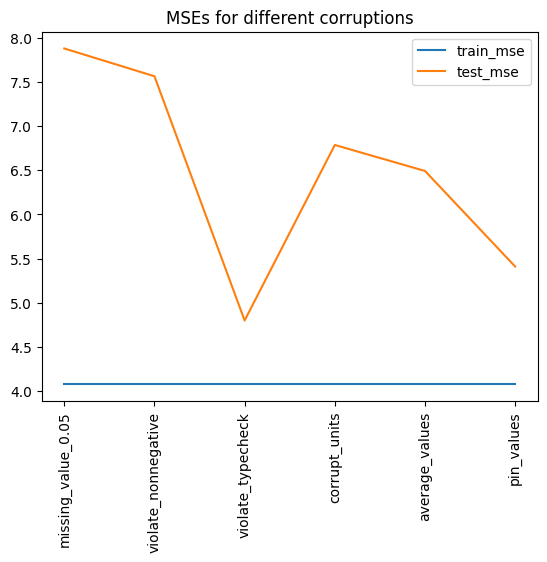

In [13]:
import matplotlib.pyplot as plt

results_df = pd.DataFrame(corruption_results)
# Log results to W&B table
run.log({"corruption_results": wandb.Table(dataframe=results_df)})
plt.plot(results_df["name"], results_df["train_mse"], label="train_mse")
plt.plot(results_df["name"], results_df["test_mse"], label="test_mse")
plt.xticks(rotation=90)
plt.legend()
plt.title("MSEs for different corruptions")
# Log plot to W&B
run.log({"corruption_plot": wandb.Image(plt)})
plt.show()

In [ ]:
run.finish()